In [1]:
#Importing MNIST dataset

from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

# 70000 images and each image has 784 features (28 x 28 pixels)

In [6]:
# Looking at one digit from data set - take an instance's feature vector, reshape it to 28 x 28 array and display 
# using Matlpotlib's imshow() function 

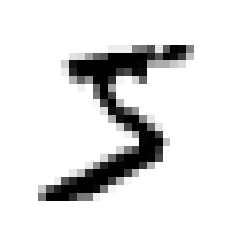

In [7]:
some_digit = X.to_numpy()[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [8]:
y[0]

'5'

In [9]:
# Above label is a string. Cast y to integer

y = y.astype(np.uint8)

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [11]:
# Creating target vectors for the class 5

y_train_5 =  (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
# Stochastic Gradient Descent (SGDC) classifier

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
#Detecting images of number 5

sgd_clf.predict([some_digit])

array([ True])

# Measuring accuracy using Cross-Validation

In [14]:
# Developing a function rather than using cross_val_score() from scikit-learn

from sklearn.model_selection import StratifiedKFold # performs stratified sampling
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [15]:
# Checking the same using cross_val_score

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

# Confusion matrix

In [16]:
# Need to have a set of predictions to compare with actual values
# Using cross_val_predict() function - it performs K-fold cross-validation but returns prediction made on each fold

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [17]:
# Getting the confusion matrix

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [18]:
# calculating precision and recall

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [20]:
# Calculating f1 score - it is the Harmonic Mean of Precision and Recall

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

# Precision-Recall Tradeoff

In [70]:
# decision_function returns score for each function

y_scores = sgd_clf.decision_function([some_digit])

In [71]:
y_scores

array([2164.22030239])

In [72]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [73]:
# How to decide threshold value? Use cross_val_predict() to get the scores of all instances in training set (specify decision_function)

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

In [74]:
# Use these scores to compute precision and recall for all possible threshold

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

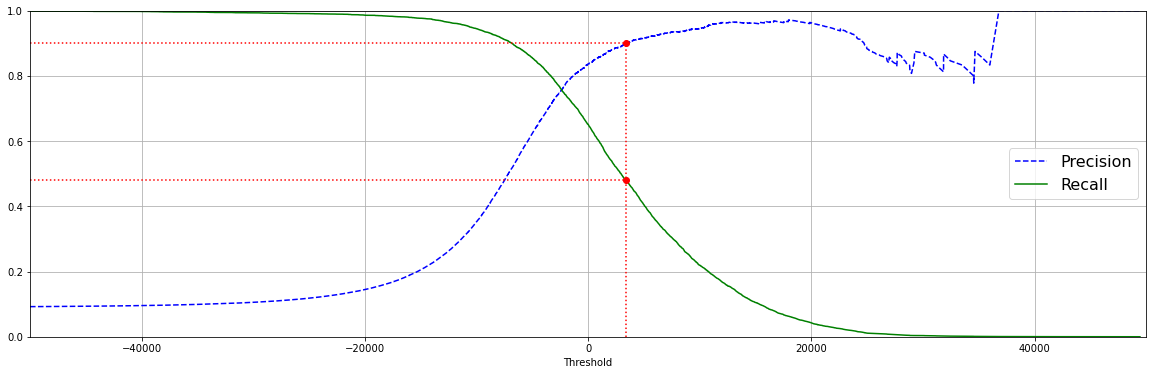

In [80]:
# Plot precision and recall as function of threshold value

plt.figure(figsize=(20,6))

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
#    plt.plot(thresholds, color='orange', linewidth=4, alpha=0.7)
    plt.xlabel('Threshold')
    plt.grid(True)
    plt.legend(loc = 'center right', fontsize = 16)
    plt.axis([-50000, 50000, 0,1 ])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0, 0.9], 'r:')
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], 'r:')
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], 'r:')
plt.plot([threshold_90_precision], [0.9], 'ro')
plt.plot([threshold_90_precision],[recall_90_precision], 'ro')
plt.show()

In [27]:
# Aim for 90% precision. Search for lowest threshold that gives you at least 90% precision
# np.argmax() will give you first index that of the maximum value 

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [28]:
# make predictions

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [31]:
# ROC Curve - plots True Positive Rate (TPR) against False Positive Rate (FPR)
# FPR is ratio of negative instances that are incorrectly classified as positive

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

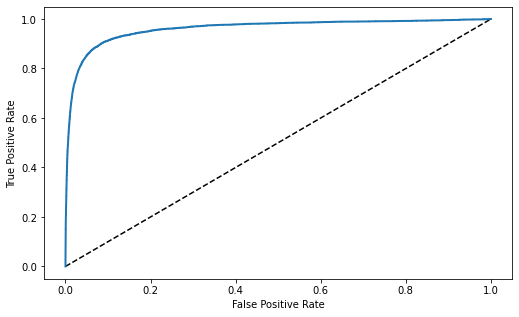

In [50]:
# Plotting
plt.figure(figsize = (10,6))

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot([0,1], [0,1], 'k--') #Dashed diagnol
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.subplots_adjust(bottom=.25, left=.25)
    

plot_roc_curve(fpr, tpr)
plt.show()

In [52]:
# Scikit-Learn provides a function to calculate ROC AUC

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [81]:
# RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')


In [82]:
# ROC Curve expects labels and scores but for RandomForestClassifier we can replace scores with class probabilities

y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

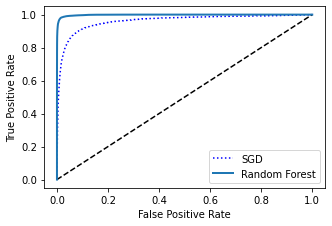

In [83]:
# Plotting ROC Curve for RandomForest

plt.plot(fpr, tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc = 'lower right')
plt.show()

In [84]:
# ROC AUC

roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [89]:
# Calculating Precision and Recall

y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [94]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# Multiclass Classification

In [90]:
# Training SVM - Binary classification algorithm - Scikit-learn decide between OvR or OvO depending on the algorithm when we 
# use binary model for multiclass classification

from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [93]:
# decision_function() returns 10 values for each class (0 to 9). Class with highest value becomes the prediction
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [95]:
np.argmax(some_digit_scores)

5

In [96]:
# SGDClassifier / RandomForestClassifier / Naive Bayes Classifier  - capable of handling multiple classes natively
# Scikit Learn did not have to run OvR or OvO this time because SGD Classifier can directly classify instanes into multiple classes
# decision_function() method now returns one value per class

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [97]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [98]:
# Evaluating model using corss-validation (cross_val_score() function)

cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy') # over 84% on all test folds

array([0.87365, 0.85835, 0.8689 ])

In [100]:
# Scaling the inputs increase accuracy above 89%

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

# Error Analysis

In [101]:
# Analysing the type of errors our model is making

# 1. Confusion matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3) # making predictions
conf_mx = confusion_matrix(y_train, y_train_pred)                          # calling confusion matrix      
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

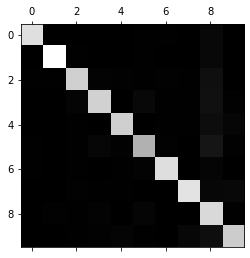

In [102]:
# Image representation of confusion matrix

plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [103]:
# Calculating error rate in each class

row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx/row_sums

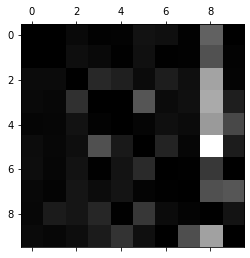

In [105]:
# Fill diagonal with zeros to keep only the errors and plot the results

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

# KNN Classifier

In [106]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights = 'distance', n_neighbors = 4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [107]:
# predicting

y_knn_pred = knn_clf.predict(X_test)

In [108]:
# Calculating accuracy

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

In [109]:
# Confusion Matrix 

conf_mx = confusion_matrix(y_test, y_knn_pred)
conf_mx

array([[ 973,    1,    1,    0,    0,    1,    3,    1,    0,    0],
       [   0, 1132,    2,    0,    0,    0,    1,    0,    0,    0],
       [  10,    5,  995,    2,    1,    0,    0,   16,    3,    0],
       [   0,    1,    3,  974,    1,   14,    1,    7,    4,    5],
       [   1,    5,    0,    0,  950,    0,    4,    3,    0,   19],
       [   4,    0,    0,    9,    2,  862,    7,    1,    3,    4],
       [   4,    2,    0,    0,    3,    3,  946,    0,    0,    0],
       [   0,   17,    4,    0,    3,    0,    0,  994,    0,   10],
       [   5,    2,    4,   14,    5,   11,    4,    4,  920,    5],
       [   3,    4,    2,    7,    9,    4,    1,   10,    1,  968]],
      dtype=int64)

In [114]:
precision_score(y_test, y_knn_pred, average = 'macro') #0.97151

0.9715597201945959

In [117]:
recall_score(y_test, y_knn_pred, average = 'macro')

0.9710823052664403